In [59]:
import numpy as np
from collections import Counter
import trueskillthroughtime as ttt
import matplotlib.pyplot as plt
import pickle
import bz2
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import log
from datetime import datetime


In [60]:
def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob+.000001)) + ((1 - result) * log(1-prob+.000001)))

In [61]:
#Plot Text Size Control
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the plot title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams['figure.figsize'] = (12, 5)


In [62]:

with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Create TrueSkill Through Time Implementation
vball.shape[0]/4


51574.0

In [63]:

with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/new_vball_game_data_alt.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_new = pickle.load(uncompressed)

#Create TrueSkill Through Time Implementation
vball_new.shape[0]/4



9667.0

In [64]:
vball[-1]

(4149, "LGBV Club AVP Winter Wonderland Qualifier '22", 'Local', '16U', '7', 'Girls', 'Juniors', 38724, 2, 127, 'Away', 1, 'Bracket', False, 24668, 4714, '4714.24668', 5105, 7622, '5105.7622', False, False, 15, 21, False, 21, -6, 0.41666666, 21, 36.974117, -122.0308, 'Pacific Standard Time', '2022-02-27T16:00:00.000000')

In [65]:
# vball_new[1395]


vball_new_clean=vball_new[(vball_new['datetime'] >= max(vball['datetime']))]
print(max(vball['datetime']))
print(min(vball_new['datetime']))
print(min(vball_new_clean['datetime']))




2022-02-27T16:00:00.000000
2021-06-12T08:00:00.000000
2022-03-05T09:00:00.000000


In [76]:
new_game_start_index=int(len(vball)/4)
new_game_start_index

51574

In [67]:
len(vball_new_clean)/4

9318.0

In [68]:
len(np.unique(vball_new_clean['tournamentId']))

138

In [85]:
vball_all=np.concatenate((vball, vball_new_clean))
# vball_all.sort(order='datetime')
print(len(vball_all)/4)


60892.0


In [86]:
vball_all['datetime'][new_game_start_index*4]

numpy.datetime64('2022-03-05T09:00:00.000000')

In [87]:


#Initialize every player into a dictionary
def initialize_players(vball=vball,mu_val=0.0,sigma_val=6.0,beta_val=1.0,gamma_val=0.03):
    unique_players=np.unique(vball['player_id'])
    player_ratings=dict()
    for i in unique_players:
        player_ratings[i]=ttt.Player(ttt.Gaussian(mu=mu_val, sigma=sigma_val),beta=beta_val,gamma=gamma_val)
    return player_ratings


def run_simulation(vball=vball,train_size=20000,mu_val=0.0,sigma_val=6.0,beta_val=1.0,gamma_val=0.03,log_loss_check=False):
    
    player_ratings=initialize_players(vball,mu_val,sigma_val,beta_val,gamma_val)
        
    #Run through every match and update mu and sigma after
    #Looping through every 4th row because the algorithm takes the both teams at once
    loop=0
    prediction=[]
    log_loss=0
    log_loss_counter=0
    final_outputs=[]
    for i in vball[::4]:
        outputs=[]
        
        ##First step is to store winning and losing team
        if i['win']==True:
            winning_team = [player_ratings[i['player_id']], player_ratings[i['teammate_id']]]
            losing_team = [player_ratings[i['opponent1_id']], player_ratings[i['opponent2_id']]]
        if i['win']==False:
            losing_team = [player_ratings[i['player_id']], player_ratings[i['teammate_id']]]
            winning_team = [player_ratings[i['opponent1_id']], player_ratings[i['opponent2_id']]]    

        #Next step is to generate a new mu and sigma for every player based on the result
        g = ttt.Game([winning_team, losing_team]) #Winning team must go first
        pos=g.posteriors()
        
        win_pct_chance=round(g.evidence,5)

        loop+=1
        if loop > train_size:
            if win_pct_chance > .5:
                prediction.append(1)
                outputs.append(1)
                log_loss+=LogLoss(True,g.evidence)
                log_loss_counter+=1
            elif win_pct_chance == .5:
                prediction.append(0)
                outputs.append(0)
            else:
                prediction.append(-1)
                outputs.append(-1)
                log_loss+=LogLoss(False,g.evidence)
                log_loss_counter+=1

            #append winning team (mu,sigma)
            outputs.append((list(pos[0][0])[0]+list(pos[0][1])[0])/2)

            #append losing team (mu,sigma)
            outputs.append((list(pos[1][0])[0]+list(pos[1][1])[0])/2)
            
            #append skill gap winning team
            outputs.append(abs(list(pos[0][0])[0]-list(pos[0][1])[0]))
            
            #append skill gap losing team
            outputs.append(abs(list(pos[1][0])[0]-list(pos[1][1])[0]))

            #append percentage points won
            if i['ignored_score']==True or i['incomplete_score']==True:
                outputs.append(-1)
            elif i['win']==True:
                outputs.append(i['pct_points_won'])
            elif i['win']==False:
                outputs.append(1-i['pct_points_won'])

            #append percent chance of winning
            outputs.append(round(g.evidence,4))
            
            #Append all of the outputs as one element
            final_outputs.append(list(outputs))

        #Next we store the new mu and sigma into the player rating dictionary
        if i['win']==True:
            player_ratings[i['player_id']]=ttt.Player(pos[0][0])
            player_ratings[i['teammate_id']]=ttt.Player(pos[0][1])
            player_ratings[i['opponent1_id']]=ttt.Player(pos[1][0])
            player_ratings[i['opponent2_id']]=ttt.Player(pos[1][1])
        if i['win']==False:
            player_ratings[i['player_id']]=ttt.Player(pos[1][0])
            player_ratings[i['teammate_id']]=ttt.Player(pos[1][1])
            player_ratings[i['opponent1_id']]=ttt.Player(pos[0][0])
            player_ratings[i['opponent2_id']]=ttt.Player(pos[0][1])

    hits=len([x for x in prediction if x==1])
    misses=len([x for x in prediction if x==-1])
    ties=len([x for x in prediction if x==0])
    if (hits+misses)!=0:
        acc=hits/(hits+misses)
    else:
        acc=0
    
    #Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning
    if log_loss_check:
        log_loss_final=log_loss/log_loss_counter
        return acc,final_outputs,log_loss_final
        
    else:
        return acc,final_outputs

def plot_acc_curve(final_acc,parameter="Input Parameter"):
    max_acc=max(final_acc,key=lambda x:x[1])
    print("Max Acc: ",max_acc[1],'\n',parameter,': ',max_acc[0],sep='')
    plt.plot([x[0] for x in final_acc], [x[1] for x in final_acc])
    plt.xticks([x[0] for x in final_acc])  # add this or the plot api will add extra ticks
    #plt.xticks(rotation=90)
    plt.xlabel(parameter)
    plt.ylabel("Accuracy")
    plt.title(label=str("Accuracy by " + parameter))
    plt.show()
    


In [89]:
acc,outputs,log_loss_final=run_simulation(vball=vball_all,train_size=new_game_start_index,mu_val=0,sigma_val=2.5,beta_val=0.5,gamma_val=0.03,log_loss_check=True)
print(acc)
print(log_loss_final)
print(Counter([x[0] for x in outputs]))

0.7351193691260668
0.2835819561704108
Counter({1: 6805, -1: 2452, 0: 61})


In [ ]:
# Values from training set
# 0.7521319463967763
# 0.27371134693799365
# Counter({1: 16052, -1: 5290, 0: 232})

In [90]:
#Plot Text Size Control
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the plot title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams['figure.figsize'] = (12, 8)


In [91]:

#Outputs contain: Binary Outcome, WT avg mu, LT avg mu, WT skill gap, LT skill gap, % points won, and % chance of winning
out_array=np.array(outputs)
out_array.shape

#Remove ties
out_array_no_ties=out_array[out_array[:,0]!=0,:]
out_array_no_ties.shape

#Create bins
lb=-4
ub=4
increment=.25
bins_lt=[[round(x*.01,2),round(x*.01+increment,2)] for x in range(int(lb*100),int(ub*100),int(increment*100))]
bins_wt=bins_lt.copy()
bins_wt.reverse()


game_count_array=np.zeros((len(bins_wt),len(bins_lt)))
exp_win_prob_array=np.zeros((len(bins_wt),len(bins_lt)))
actual_win_prob=np.zeros((len(bins_wt),len(bins_lt)))


#Capture game count in each bin (after training)
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                game_count_array[ix,iy]+=1

#Capture expected win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                exp_win_prob_array[ix,iy]+=i[6]/game_count_array[ix,iy]

#Capture actual win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1] and i[0]==1:
                actual_win_prob[ix,iy]+=i[0]/game_count_array[ix,iy]

#Capture residual of actual - expected win probability
residual_win_prob=actual_win_prob-exp_win_prob_array


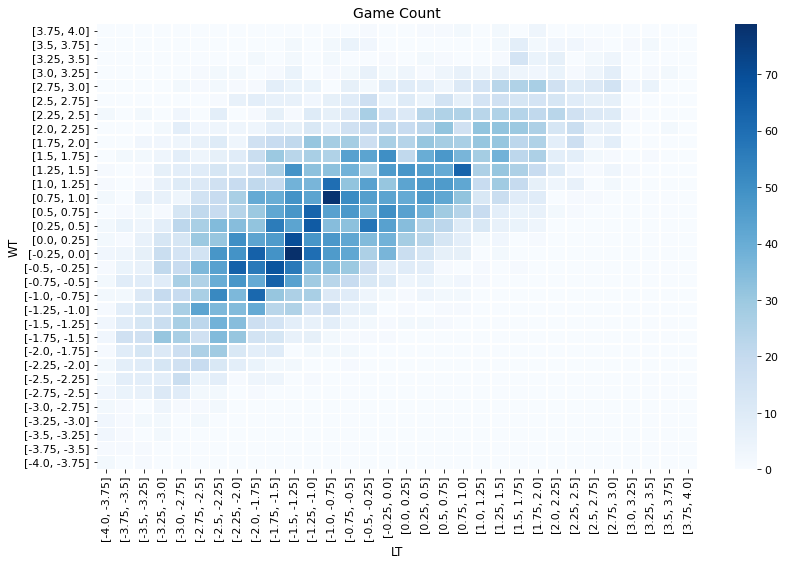

In [92]:

#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Game Count")
plt.tight_layout()
plt.show()


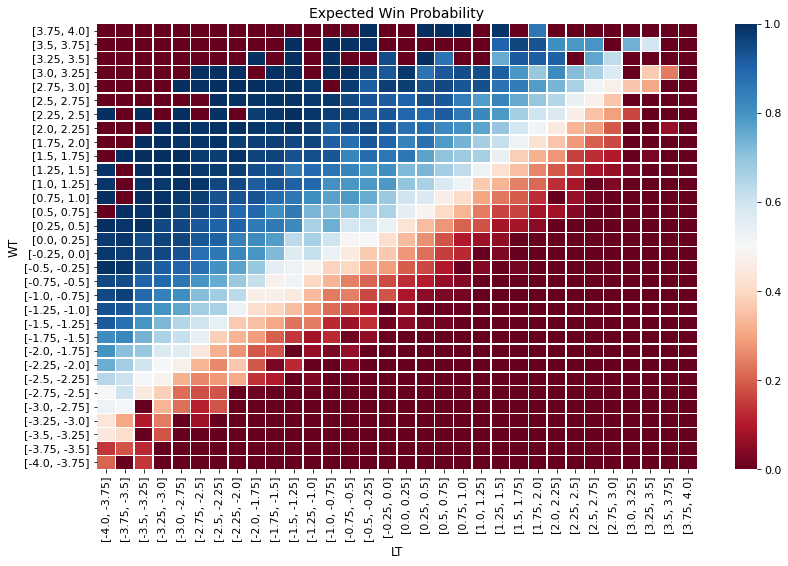

In [93]:

#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Expected Win Probability")
plt.tight_layout()
plt.show()


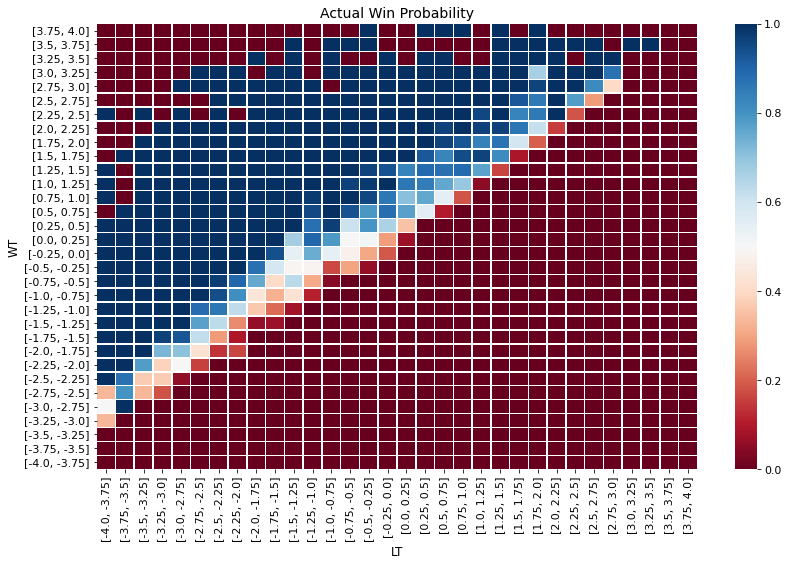

In [94]:

#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Actual Win Probability")
plt.tight_layout()
plt.show()


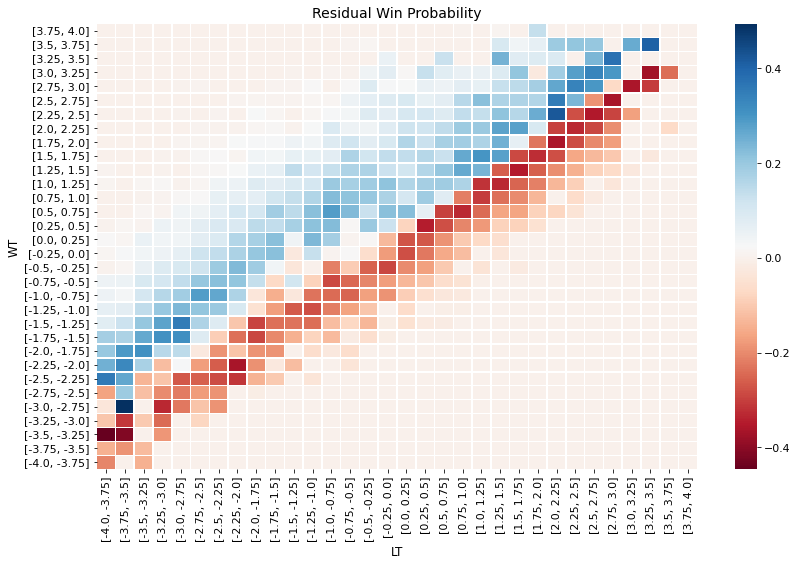

In [95]:

#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=bins_lt,
    yticklabels=bins_wt,
    linewidth=0.5,
)
plt.xlabel("LT")
plt.ylabel("WT")
plt.title("Residual Win Probability")
plt.tight_layout()
plt.show()

In [96]:
#Average probability miss per game (weighted average of non-absolute value of residuals)
#need to include for extreme ratings
np.sum(np.multiply(residual_win_prob,game_count_array/np.sum(game_count_array)))

0.06688705972434912

In [97]:
#Average probability miss per game (weighted average of absolute value of residuals)
#need to include for extreme ratings
np.sum(np.multiply(np.absolute(residual_win_prob),game_count_array/np.sum(game_count_array)))

0.15257283964121632

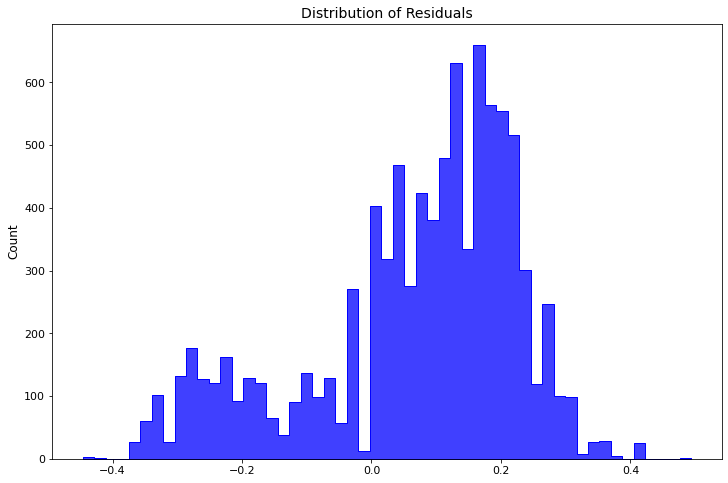

In [98]:
game_list=[y for x in game_count_array for y in x]
residual_win_prob_list=[y for x in residual_win_prob for y in x]
residual_holder_list=[]

for i in range(len(game_list)):
    if game_list[i]>0:
        residual_holder_list=residual_holder_list+[residual_win_prob_list[i]]*int(game_list[i])

#Distribution of ratings of winning team when correct vs incorrect
sns.histplot(residual_holder_list, element="step",color='blue')
plt.title('Distribution of Residuals')
plt.show()